In [1]:
from src.models import Exponential_Model
from src.criterion import right_censored,RightCensorWrapper,RankingWrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import visualize_population_curves_attacked,visualize_individual_curves_attacked,visualize_individual_curves_changes
from src.metrics import concordance

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
class ARGS(object):
    def __init__(self):
        pass

In [3]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=30
args.lr = 1e-3
args.batch_size= 512
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=5,length=20"
args.hidden_dims = [15,15]
args.save_model = ""
args.dataset = "Dialysis"


In [4]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [5]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [6]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([5444, 74])

In [7]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))


# # model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(RightCensorWrapper(clf_robust),dataloader_train.dataset.tensors)
model_fragile_wrap = BoundedModule(RightCensorWrapper(clf_fragile),dataloader_train.dataset.tensors)

In [8]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=6089.4375 Time=0.0029
[ 1:  10]: eps=0.00000000 Loss=5753.9611 Time=0.0028
[ 1:  10]: eps=0.00000000 Loss=5753.9611 Time=0.0028
Epoch time: 0.0540, Total time: 0.0540
Evaluating...
[ 1:   2]: eps=0.00000000 Loss=5216.7169 Time=0.0017
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=5506.2539 Time=0.0023
[ 2:  10]: eps=0.00000000 Loss=5277.9234 Time=0.0030
[ 2:  10]: eps=0.00000000 Loss=5277.9234 Time=0.0030
Epoch time: 0.0567, Total time: 0.1106
Evaluating...
[ 2:   2]: eps=0.00000000 Loss=4779.0902 Time=0.0014
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=5097.0703 Time=0.0033
[ 3:  10]: eps=0.00000000 Loss=4823.6981 Time=0.0029
[ 3:  10]: eps=0.00000000 Loss=4823.6981 Time=0.0029
Epoch time: 0.0545, Total time: 0.1651
Evaluating...
[ 3:   2]: eps=0.00000000 Loss=4326.1794 Time=0.0013
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=4737.9360 Time=0.0030
[ 4:  10]: eps=0.00000000 Lo

In [9]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=6089.4375 Time=0.0060
[ 1:  10]: eps=0.00000000 Loss=5753.9611 Time=0.0045
[ 1:  10]: eps=0.00000000 Loss=5753.9611 Time=0.0045
Epoch time: 0.0950, Total time: 0.0950
Evaluating...
[ 1:   2]: eps=0.00000000 Loss=5216.7169 Time=0.0020
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=5506.2539 Time=0.0040
[ 2:  10]: eps=0.00000000 Loss=5277.9234 Time=0.0043
[ 2:  10]: eps=0.00000000 Loss=5277.9234 Time=0.0043
Epoch time: 0.0776, Total time: 0.1726
Evaluating...
[ 2:   2]: eps=0.00000000 Loss=4779.0902 Time=0.0023
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=5097.0703 Time=0.0049
[ 3:  10]: eps=0.00000000 Loss=4823.6981 Time=0.0039
[ 3:  10]: eps=0.00000000 Loss=4823.6981 Time=0.0039
Epoch time: 0.0746, Total time: 0.2472
Evaluating...
[ 3:   2]: eps=0.00000000 Loss=4326.1794 Time=0.0024
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=4737.9360 Time=0.0040
[ 4:  10]: eps=0.00000000 Lo

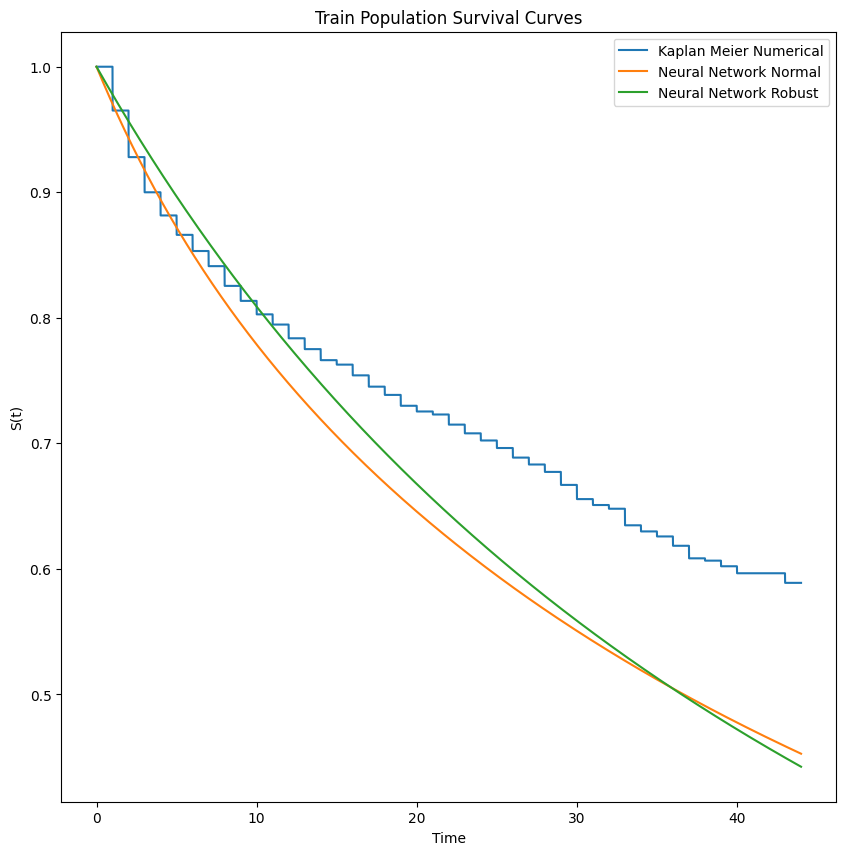

In [10]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_fragile_x.mean(0))
plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.show()

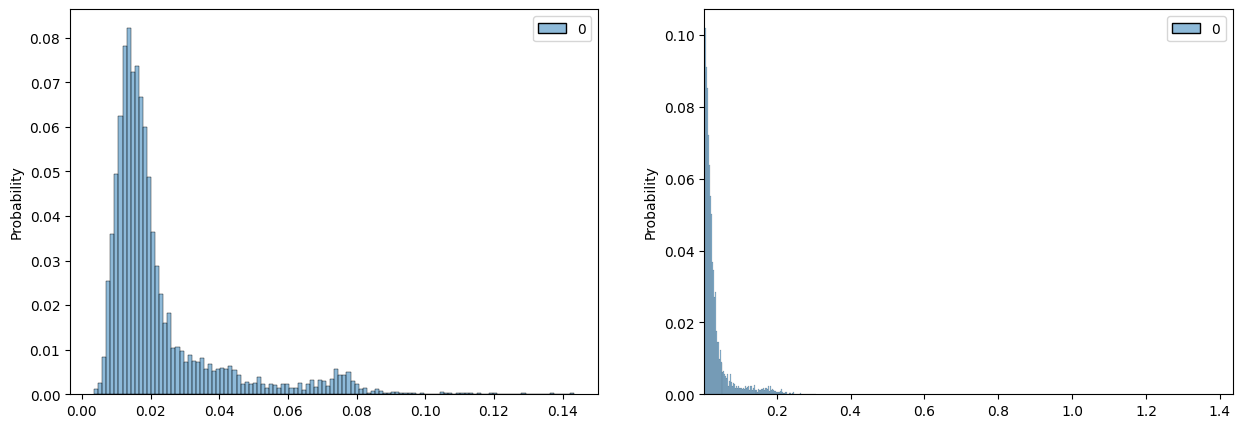

In [11]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
lambda_robust = clf_robust(X_train).detach()
lambda_fragile = clf_fragile(X_train).detach()
sns.histplot(lambda_robust,ax=axes[0],stat="probability")
axes[1].set_xlim([lambda_robust.min(),lambda_robust.max()*10])
sns.histplot(lambda_fragile,ax=axes[1],stat="probability")
plt.show()

ROBUST CLF
CI @ eps=10 0.4092528548881255
CI @ eps=5 0.5320437312084443
CI @ eps=2 0.6364418702641709
CI @ eps=1 0.6906918863329596
CI @ eps=0.8 0.7010209929797248
CI @ eps=0.7 0.7045940666890439
CI @ eps=0.6 0.7069849685408826
CI @ eps=0.5 0.7094567722802683
CI @ eps=0.1 0.7106763263892361
CI @ eps=0.07 0.7102256191839912
CI @ eps=0.05 0.7098389639559215
CI @ eps=0 0.7088607764438699
NONROBUST CLF
NaN values in UB!
CI @ eps=10 0.500852761689151
NaN values in UB!
CI @ eps=5 0.4945030236104069
CI @ eps=2 0.48061389914514047
CI @ eps=1 0.5243390817937054
CI @ eps=0.8 0.5463857946551638
CI @ eps=0.7 0.5618204241446049
CI @ eps=0.6 0.5826581838340844
CI @ eps=0.5 0.6114060279382673
CI @ eps=0.1 0.7410773587196389
CI @ eps=0.07 0.7427757404140748
CI @ eps=0.05 0.7428732690343729
CI @ eps=0 0.7413125879319826


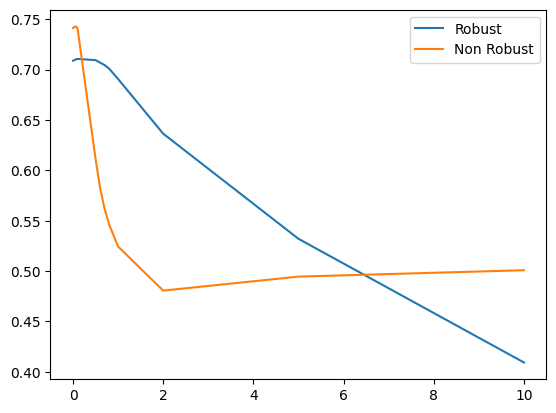

In [12]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_train,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_train,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

tensor([0.0037, 0.0091, 0.0202, 0.0211, 0.0224, 0.0283, 0.0298, 0.0321, 0.0376,
        0.0444])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.86it/s]


tensor([50.8657, 49.0965, 45.2949, 44.7814, 43.8165, 43.2445, 42.7111, 42.1295,
        40.6433, 40.3789])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.68it/s]


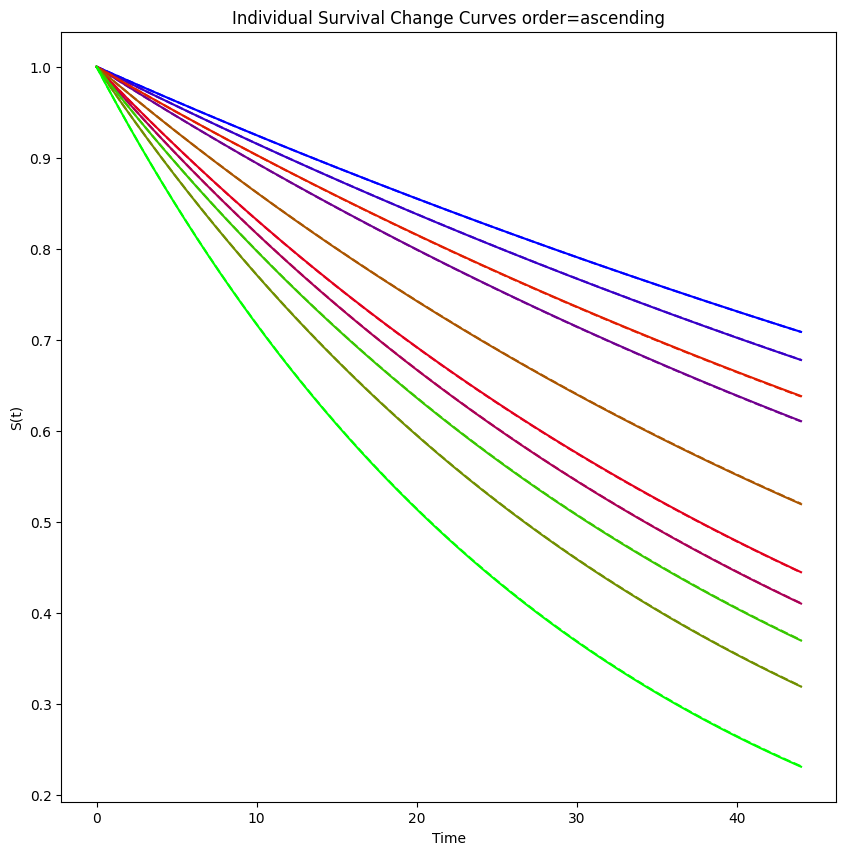

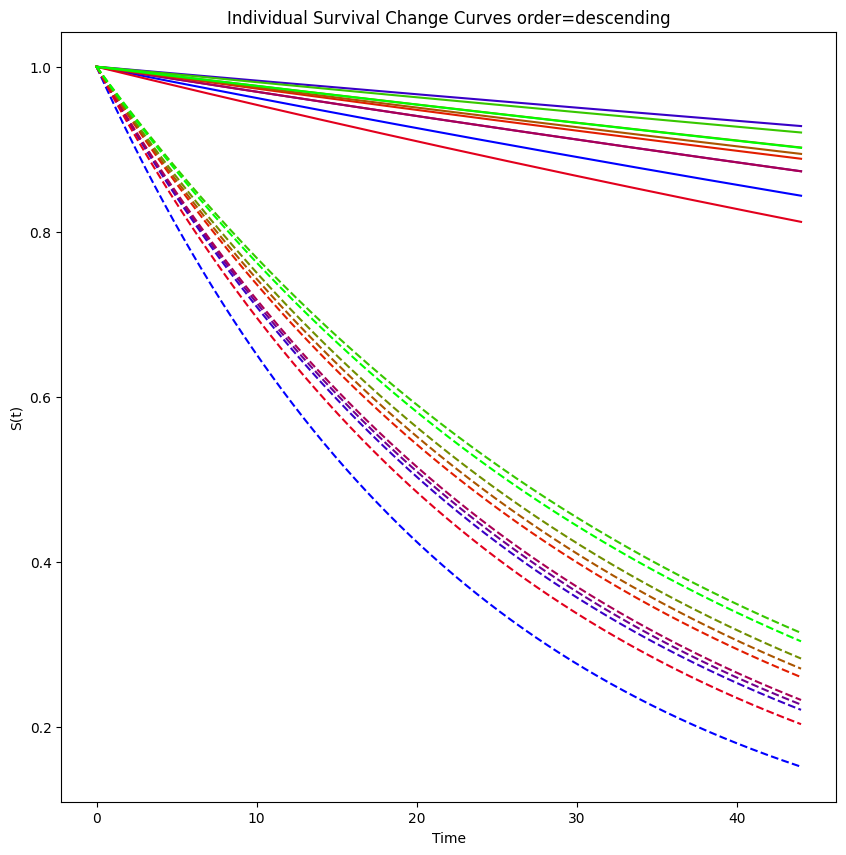

In [13]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="descending",test_cases=10)

tensor([0.0037, 0.0091, 0.0202, 0.0211, 0.0224, 0.0283, 0.0298, 0.0321, 0.0376,
        0.0444])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


tensor([41.3789, 41.1410, 38.0775, 37.4745, 36.3409, 32.6565, 31.7055, 31.2672,
        30.6910, 29.6334])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.95it/s]


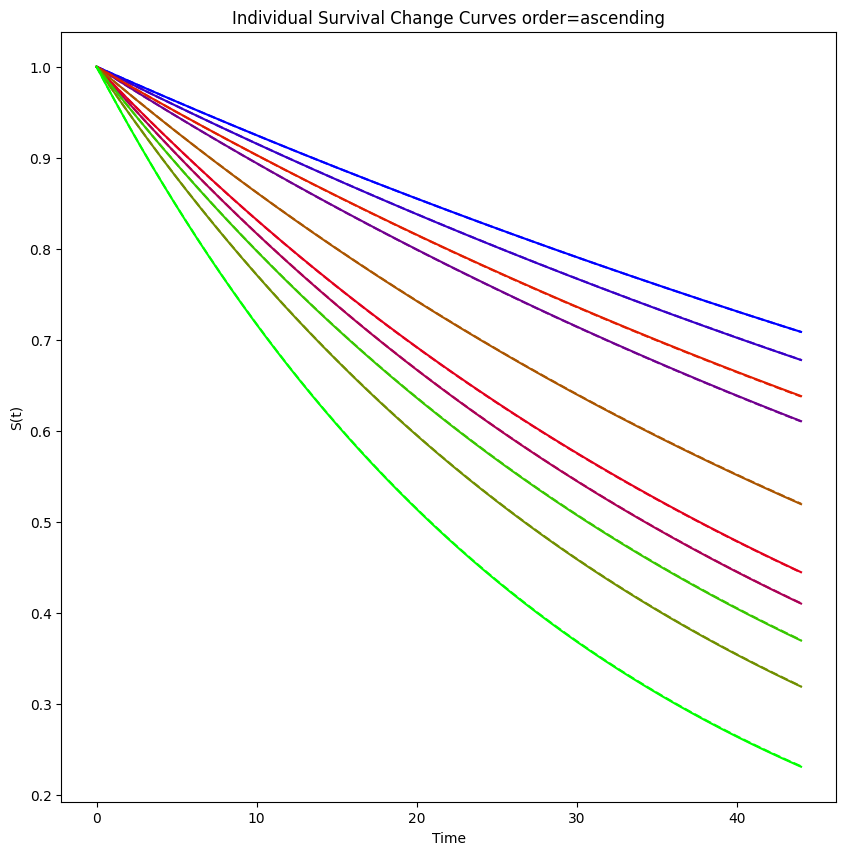

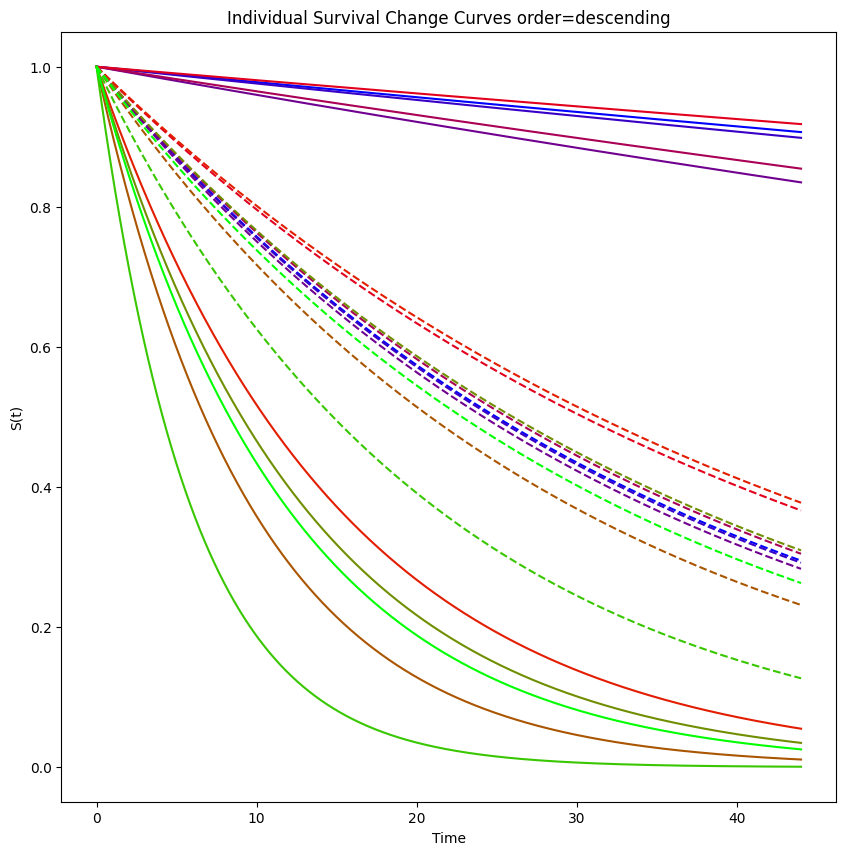

In [14]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="descending",test_cases=10)

<Figure size 1000x1000 with 0 Axes>

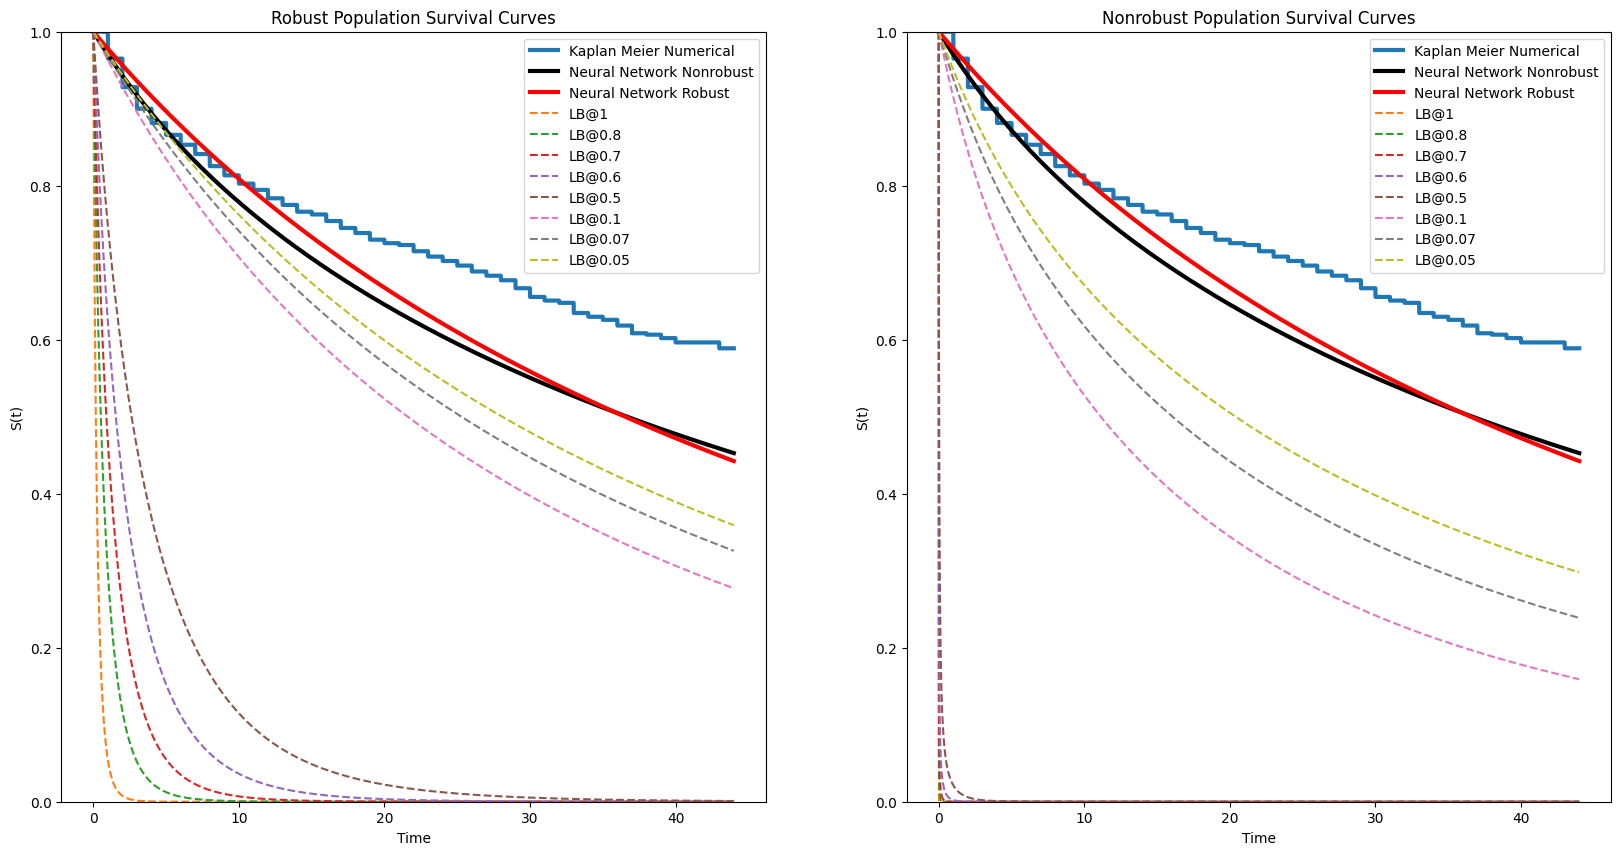

<Figure size 1000x1000 with 0 Axes>

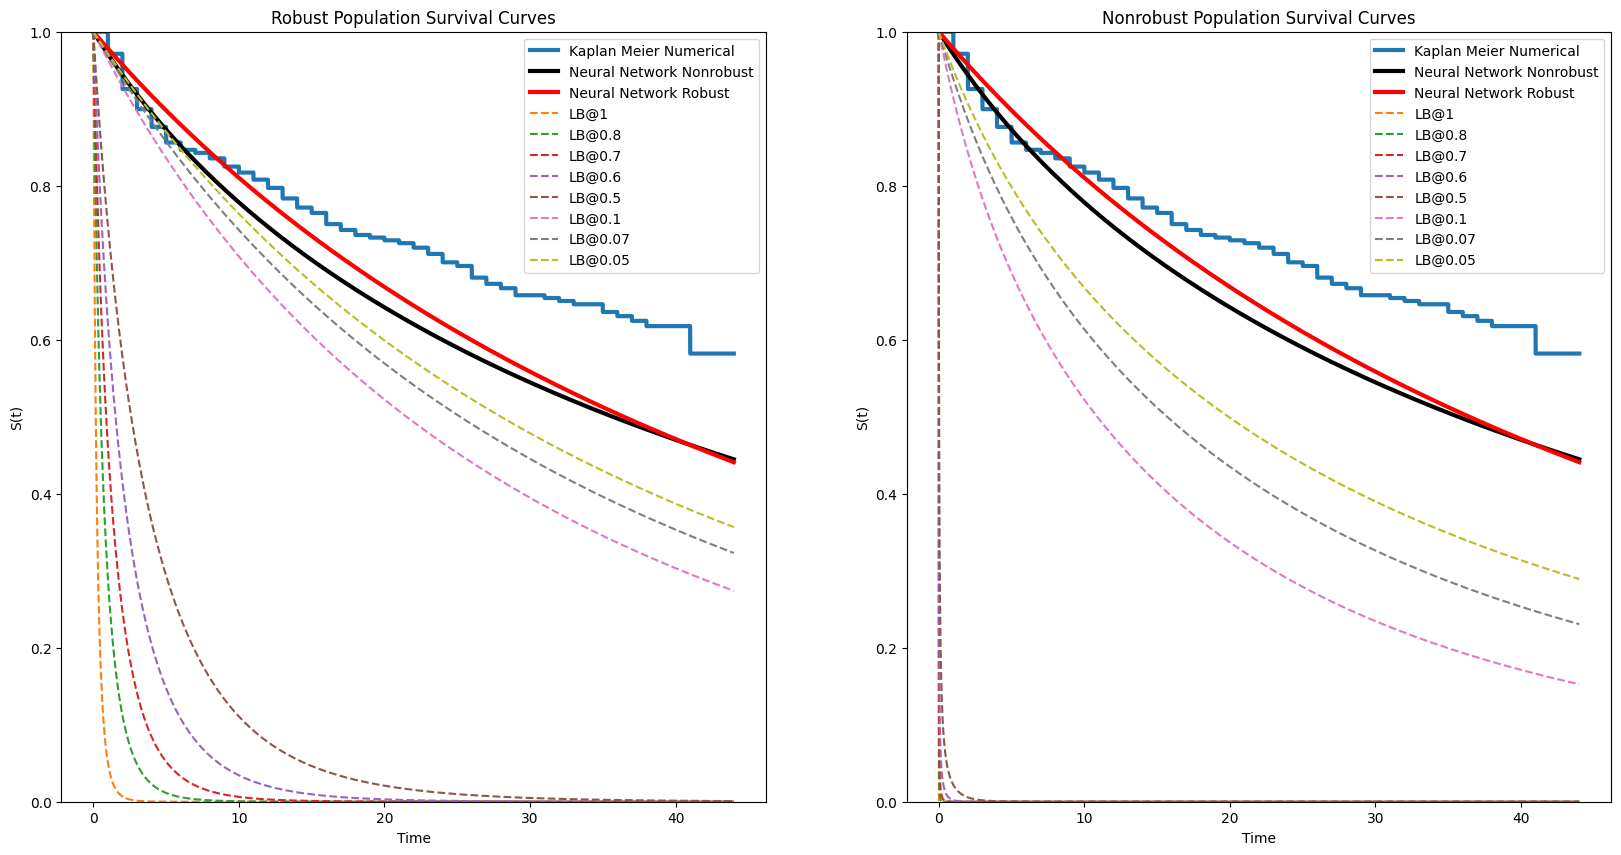

In [15]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons)
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)

<Figure size 1000x1000 with 0 Axes>

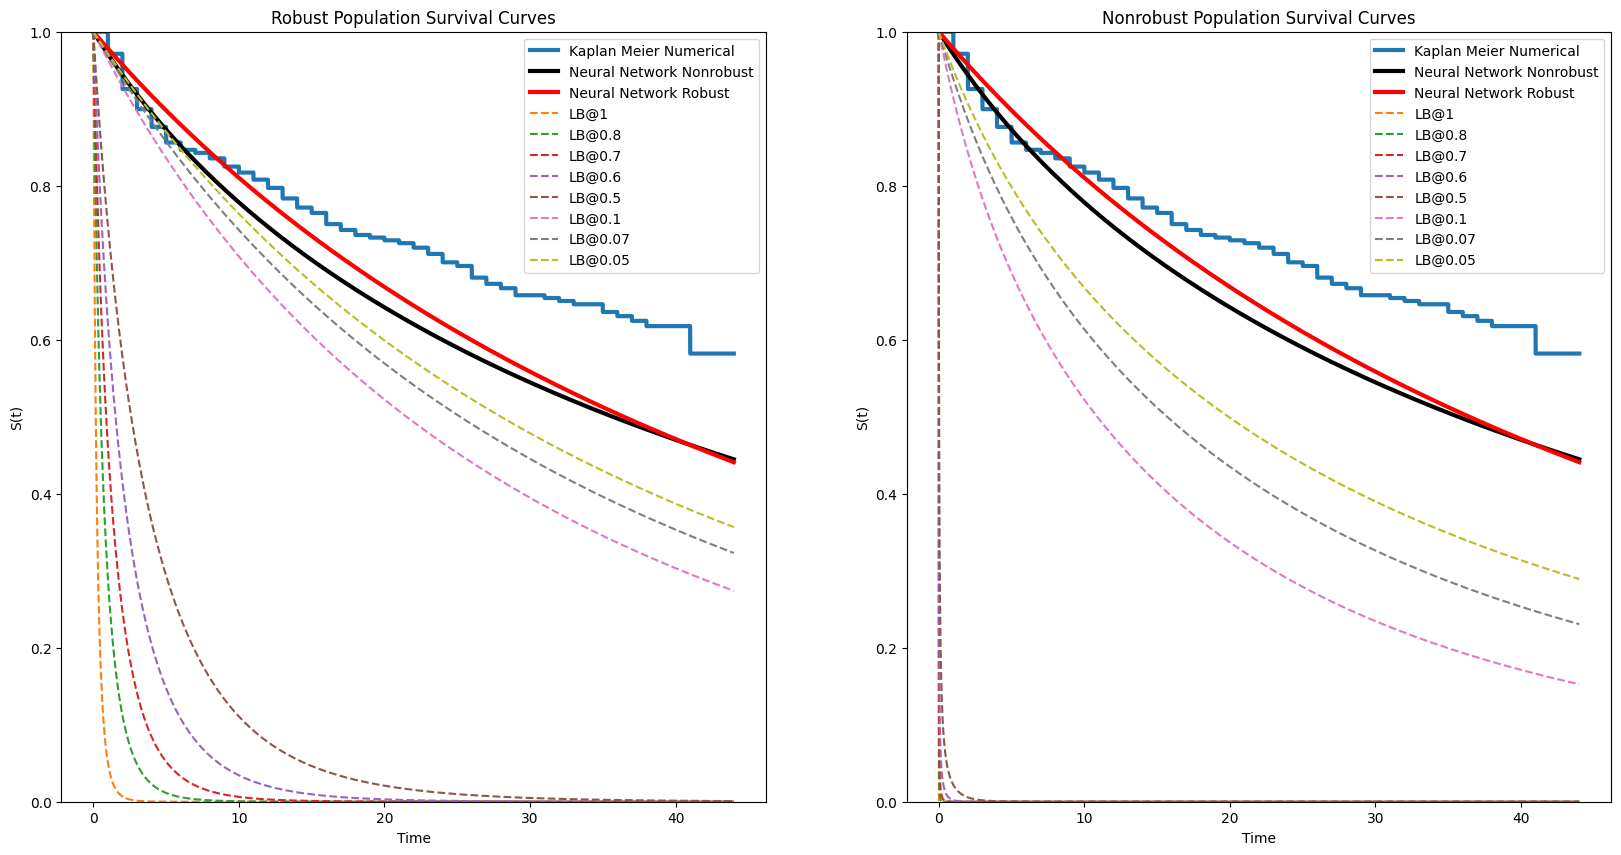

In [16]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)

In [ ]:
eps = 0.3
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="ascending",test_cases=10)

visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="ascending")

tensor([52.2261, 52.0768, 50.5868, 50.5373, 50.4774, 50.4710, 50.4517, 50.4111,
        50.4055, 50.3953])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.88it/s]


tensor([15.9635, 16.6818, 17.5570, 17.5650, 17.9587, 18.9212, 19.5743, 21.7420,
        22.5815, 23.1123])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.92it/s]


tensor([52.2523, 50.3850, 50.2073, 50.1553, 50.1523, 50.1521, 50.1408, 50.0952,
        50.0674, 50.0290])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9/10 [00:03<00:00,  2.83it/s]